#Assignment 1:
    test if the distribution of ages is the same for 
    
    1) male and femal riders
    
    2) day and night riders
    
    use 3 tests: KS, Pearson's, Spearman's

my usual imports and setups

In [174]:
import pylab as pl
import pandas as pd
import numpy as np
import os
%pylab inline

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
pl.rcParams.update(s)

np.random.seed(2015)

Populating the interactive namespace from numpy and matplotlib


## I. Getting data

In [17]:
# import os
# for x in os.environ: print x
#import os
# myPath = os.getenv ('PUI2015') # dont work for me, have no idea why
# print myPath

In [125]:
import requests
import zipfile
import StringIO


def urlZipToDF(url):
    name = url.split('/')[-1].replace('zip','csv')
    r = requests.get(url)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    csvZ = [x for x in z.namelist() if '.csv' in x][0] #simply first csv in list
    return pd.read_csv(z.open(csvZ))


def getCitibikeData(year, month):
    url = 'https://s3.amazonaws.com/tripdata/%d%s-citibike-tripdata.zip' %(year, ("%02d" % month))
    return urlZipToDF(url)

In [126]:
mdf = getCitibikeData(2014,10)

**Ph: I am using october 2014 data**

In [10]:
print "Before filtering:", len(df)
df = mdf[mdf['usertype'] == 'Subscriber'][['birth year','gender']] ## removed customers
print "After filtering:", len(df)

print df.columns

Before filtering: 828711
After filtering: 759628
Index([u'birth year', u'gender'], dtype='object')


#BY GENDER
splitting data by gender and extracting the age happens in the cell below

In [11]:
#df is the dataframe where the content of the csv file is stored
df['age'] = 2015.0-df['birth year'].astype(float)

In [14]:
males = df[df['gender'] == 1]
females = df[df['gender'] == 2]
             
print 'Males:', len(males)
print 'Females:', len(females)

Males: 587237
Females: 172111


lets split age in 10 year bins. the dataset is very large, so i could be split in smaller bins, but I will chose 10 years in the interest of time. if i was to do this "for real" the bin size choice should be a balance between properly sample the age space, have enough counts in each bin that the statistical noise is not significant (remember that is > sqrt(N)!) and the computational requirement to computatinal facilities ratio. 

the next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

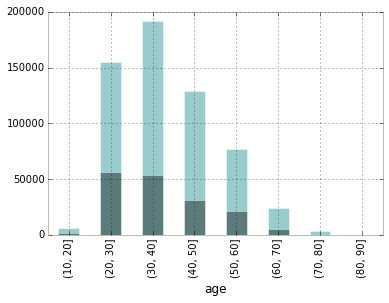

In [26]:
bins = np.arange(10, 99, 10) ## bins


ax = males.age.groupby(pd.cut(males.age, bins)).agg([count_nonzero]).plot(kind='bar', legend=0, alpha = 0.4,  color='teal')
females.age.groupby(pd.cut(females.age, bins)).agg([count_nonzero]).plot(kind='bar', legend=0, alpha = 0.4, ax=ax, color='k')

this is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to reat an observed distribution like a probablility distribution i have to normalize it

          count_nonzero
age                    
(10, 20]       0.001968
(20, 30]       0.065516
(30, 40]       0.053657
(40, 50]       0.018060
(50, 60]       0.013701
(60, 70]       0.003284
(70, 80]       0.000065
(80, 90]       0.000000


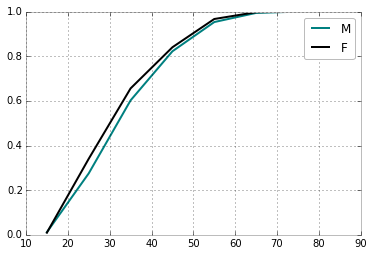

In [27]:
#print df.ageS, df.ageS.cumsum()

csM= males.age.groupby(pd.cut(males.age, bins)).agg([count_nonzero]).cumsum()
csF= females.age.groupby(pd.cut(females.age, bins)).agg([count_nonzero]).cumsum()

print np.abs(csM / csM.max()-csF / csF.max())

pl.plot(bins[:-1] + 5, csM / csM.max(), label = "M", color='teal')
pl.plot(bins[:-1] + 5, csF / csF.max(), label = "F", color = 'k')
pl.legend()

they look pretty darn similar! that sets my expectation for the tests to come. if i wanted to code the KS test by hand i woud have everything i need: the normalized cumulative distributions can be subtracted from each other and the max distance can be seeked. 

Notice that there amay be Nan values you are gonna have to deal with! you can do that for example with a Boolean statementsuch as  df.ageF[~np.isnan(df.ageF)] or you can use numpy functions that deal with Nan values: nansum, nanmean, nanstd...

In [28]:
print len(males)
print len(females)

587237
172111


In [99]:
# #now lets downsample
# cleanM = np.random.choice(cleanM,len(cleanF),replace=True)
# print len(cleanM)
# print len(cleanF)

172111
172111


lets run the scipy KS test

In [30]:
import scipy.stats

# KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html


In [105]:
def myKS(a,b):
    bins = np.arange(float(min(a.min(),b.min())), float(max(a.max(),b.max())))
#     print bins
    csA= a.groupby(pd.cut(a, bins)).agg([count_nonzero]).cumsum()
    csB= b.groupby(pd.cut(b, bins)).agg([count_nonzero]).cumsum()
    
    difference=np.abs(csA / csB.max()-csB / csB.max())
    D = max(difference)
    
    Dcrit = 1.36*sqrt((len(a)+len(b))/float(len(a)*len(b)))
    return D<Dcrit
                            

In [108]:
print 'According to my hobmebrewed KS null hpotsis can be rejected:', myKS(males.age, females.age)

According to my hobmebrewed KS null hpotsis can be rejected: True


In [109]:
ks = scipy.stats.ks_2samp(males.age, females.age)
print ks

Ks_2sampResult(statistic=0.07351074907986449, pvalue=0.0)


**scipy thinks the same (pvalue is very small)**

# Pearson's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



In [103]:
#please perform the Pearson's test and tell me what you find
scipy.stats.pearsonr(cleanM, cleanF)

(0.0023107673485576415, 0.33773744740203604)

# Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

### please perform the Spearman's test and tell me what you find

In [116]:
print len(males)
print len(females)

587237
172111


In [119]:
malesR = np.random.choice(males.age,len(females.age),replace=True)
femalesR = females.age
print len(malesR)
print len(femalesR)

172111
172111


In [121]:
print scipy.stats.pearsonr(malesR, femalesR)

(0.00058660971230920813, 0.80772598540573937)


In [122]:
print scipy.stats.spearmanr(malesR, femalesR)

SpearmanrResult(correlation=0.00014033565560908298, pvalue=0.95357371159259463)


**Still P-values are too large to say that there is no corellation betveen ages, both for Pearson and Spearman...**

## II. Night trips

In [141]:
df = mdf
print df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'hour'],
      dtype='object')


In [142]:
#10/1/2014 00:00:27

dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M:%S').hour
df['hour'] = df.starttime.apply(dateparse)

In [143]:
df = df[df['usertype'] == 'Subscriber'] ## removed customers

In [146]:
# split data into day/nights

def ifDay(h):
    if (6 < h < 22 ):  return True 
    return False
    
df['Daytime'] = df.hour.apply(lambda x: ifDay(x))
df['Daytime'].value_counts()

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


True     691894
False     67734
dtype: int64

In [154]:
df['age'] = 2015.0-df['birth year'].astype(float)

Day = df[df['Daytime']==True]
Night = df[df['Daytime']==False]

print len(Day)
print len(Night)

691894
67734


/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


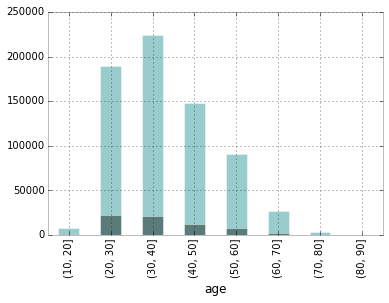

In [157]:
ax = Day.age.groupby(pd.cut(Day.age, bins)).agg([count_nonzero]).plot(kind='bar', legend=0, alpha = 0.4,  color='teal')
Night.age.groupby(pd.cut(Night.age, bins)).agg([count_nonzero]).plot(kind='bar', legend=0, alpha = 0.4, ax=ax, color='k');

          count_nonzero
age                    
(10, 20]       0.001506
(20, 30]       0.064525
(30, 40]       0.062235
(40, 50]       0.029801
(50, 60]       0.015905
(60, 70]       0.003047
(70, 80]       0.000253
(80, 90]            NaN


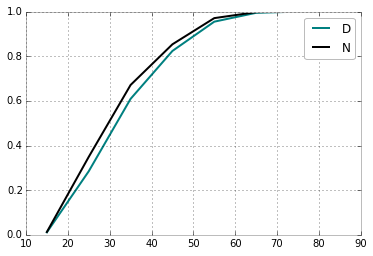

In [159]:
csD= Day.age.groupby(pd.cut(Day.age, bins)).agg([count_nonzero]).cumsum()
csN= Night.age.groupby(pd.cut(Night.age, bins)).agg([count_nonzero]).cumsum()

print np.abs(csD / csD.max()-csN / csN.max())

pl.plot(bins[:-1] + 5, csD / csD.max(), label = "D", color='teal')
pl.plot(bins[:-1] + 5, csN / csN.max(), label = "N", color = 'k')
pl.legend();

In [160]:
ks=scipy.stats.ks_2samp(Night.age, Day.age)
print ks

Ks_2sampResult(statistic=0.073690756164027871, pvalue=1.0559995340432241e-291)


**P-value s large, so we cant reject the hypotesis that both cyclists samples are of the same population**

In [161]:
print len(Day)
print len(Night)

691894
67734


In [176]:
#downsampling
DayA = pd.Series(np.random.choice(Day.age,len(Night.age)))
NightA = Night.age
print len(DayA)
print len(NightA)

67734
67734


In [177]:
scipy.stats.pearsonr(DayA, NightA)

(-4.5763966620934773e-05, 0.99049726111599279)

In [178]:
scipy.stats.spearmanr(DayA, NightA)

SpearmanrResult(correlation=0.00054069002373302675, pvalue=0.88809423974436696)

**Both Spearman and Pearson has a large P-value, so we can't  reject the Hypotesis that those parameters (Age of night cyclists vs age of day cyclists) corellate**